# Identify Surfaces

This notebook will:

* Open the SAR data
* Adjust it to the same winter means of each type (optional?)
* calculate melt season start
* calculate melt season end
* Determine if firn or bare ice
* determine if percolation
* determine if aquifer
* determine if dry snow


In [64]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX

#capture
from datetime import datetime,timedelta
from scipy import stats
import glob
import json # for loads
import os
from pathlib import Path
import pytz
import re
import shutil
import asf_search as asf
from zipfile import ZipFile
import time

from matplotlib import pyplot as plt
import matplotlib
matplotlib.use('Agg')
#Writing Support Functions:

import numpy as np
from osgeo import gdal,osr

from IPython.display import HTML, display, clear_output, Markdown
    
from hyp3_sdk import Batch, HyP3

import opensarlab_lib as asfn

URLWidget()

In [2]:
##Set path and open data##
projdir = Path.home()/"GlacierSARdata"
projname = 'Wrangell'
year = 2019
data_dir=Path(f'{projdir}/{projname}/{str(year)}')
pols = ['VV','VH']

# Setting Paths
analysis_directory = Path.cwd()/data_dir
print(f"analysis_directory: {analysis_directory}")

download_path = analysis_directory/"rtc_download"
products_path = analysis_directory/"rtc_products"
clipped_path = analysis_directory/"rtc_clipped"

#Open metadata
usepol = 'VV'
(arraykey,pnamelist,mnamelist,mdatelist,mpflist,mpfulist) = np.load(f'{str(analysis_directory)}/imgmeta_{usepol}.npy',allow_pickle=True)
mpfunique = np.unique(mpfulist)

# #Open data:
# shp = np.shape(gdal.Open(pnamelist[0]).ReadAsArray())
# data = np.empty(shape=[len(pnamelist),shp[0],shp[1]])
# for i,name in enumerate(pnamelist):
#     cdata = gdal.Open(name).ReadAsArray()
#     cdata[cdata==0]=np.nan
#     cdata[np.abs(cdata)>=60]=np.nan
#     data[i,:]=cdata


analysis_directory: /home/jovyan/GlacierSARdata/Wrangell/2019


In [3]:
# adjust timeseries
# This will bring the timeseries to have zeros for the mean value of each pixel, BUT it will
# also have 

wstart = datetime(year,1,1,0,0,0)
wend = datetime(year,4,1,1,0,0,0)

mpfu = np.array(mpfulist)
klen,ilen,jlen = np.shape(data)
datelist = np.array(mdatelist)
if type(datelist)==tuple:
    datelist = np.array(datelist)

wmeanvals = np.zeros((len(mpfunique),ilen,jlen))
for m,mpf in enumerate(mpfunique):
    dstack = data[mpfu==mpf]     #datastack
    tlist = datelist[mpfu==mpf]  #datelist
    # print(np.shape(dstack))
    
    #dstack should data. Datelist should be list of dates.
    #Both of these should ONLY be from images of the same path-frame

    winterlist = np.zeros(len(tlist))
    winterlist[(tlist > wstart) & (tlist < wend)] = 1
    winterlist = np.array(winterlist,dtype=bool)
    dstack = dstack[winterlist]
    wmeanvals[m] = np.nanmean(dstack,axis=0)
    
wmeanmap=np.nanmean(wmeanvals,axis=0)
for m,mpf in enumerate(mpfunique):
    #to correct:
    corrmap = wmeanmap - wmeanvals[m]
    data[mpfu==mpf] += corrmap
    
    #to get winter means:
    # data[mpfu==mpf] -= wmeanvals[m]
    
# plt.figure()
# plt.imshow(data[0])
# 
# plt.figure()
# plt.imshow(data[1])

In [3]:
def opendatachunk(chunkmeta, n, admeta=None, pfulist=None):
    """Opens the nth chunk"""
    pnamelist,istart,iend,jstart,jend,b,shp = chunkmeta
    istart = istart[n]
    iend = iend[n]
    jstart = jstart[n]
    jend = jend[n]
    
    doadjust = False
    if type(admeta)==np.ndarray:
        doadjust = True
        if pfulist==None:
            print('bruh')
            return
            

    chunkshp = (shp[0],iend-istart,jend-jstart)
    data = np.empty(shape=chunkshp)
    for i,name in enumerate(pnamelist):
        cdata = gdal.Open(name).ReadAsArray()[istart:iend,jstart:jend]
        cdata[cdata==0]=np.nan
        cdata[np.abs(cdata)>=60]=np.nan
        if doadjust:
            cdata-=admeta[pfulist[i],istart:iend,jstart:jend]
        
        data[i,:]=cdata

        # print(cdata[0,0])
        # data = np.append(data,[cdata],axis=0)
    # print(np.shape(data))
    # data[np.abs(data)>60]=np.nan
    return data
    

def opendatamem(pnamelist,maxsz = 5e8):
    """Creates the metadata required for opendatachunk() to work.
    Chunk meta is a tuple (pnamelist,istart,iend,jstart,jend,b2,shp)
    
    pnamelist - the input file name list
    istart,iend,jstart,jend - i,j indices of each chunk
    b2 - number of boxes
    shp - shape entire image (number of layers, ilen, jlen)
    """
    shp_img = np.shape(gdal.Open(pnamelist[0]).ReadAsArray())
    shp = [len(pnamelist)]
    [shp.append(i) for i in shp_img]
    shp = tuple(shp)
    totsz = 1
    klen,ilen,jlen = shp
    
    for i in shp:
        totsz *= i
    cmin = np.ceil(totsz/maxsz)
    
    if totsz < maxsz:
        print('just one chunk')
    else:
        print(f'chunky: {int(cmin)**2}')
    
    stoploop = True
    b=1
    while cmin>b**2:
        b+=1
    b2 = b**2

    # print(f'chunks: {b2}')
    iclen = np.floor(ilen/b)
    jclen = np.floor(jlen/b)
    # print(iclen)
    # print(jclen)
    
    istart,jstart,iend,jend = [],[],[],[]
    
    for i in range(b):
        iadd=0
        if i==b-1:
            iadd = ilen-(i+1)*iclen
        for j in range(b):
            istart.append(int(i*iclen))
            jstart.append(int(j*jclen))
            
            jadd=0
            if j==b-1:
                jadd = jlen-(j+1)*jclen
            
            iend.append(int(istart[-1]+iclen+iadd))
            jend.append(int(jstart[-1]+jclen+jadd))
        
        
        # iend.append(istart[-1]+iclen-1)
        # jend.append(jstart[-1]+jclen-1)
    
    chunkmeta = pnamelist,istart,iend,jstart,jend,b2,shp
    return(chunkmeta)

def opendatavec(pnamelist,ipt,jpt,admeta=None, pfulist=None):
    dvec = []
    for name in pnamelist:
        dvec.append(gdal.Open(name).ReadAsArray()[ipt,jpt])
    
    doadjust = False
    if type(admeta)==np.ndarray:
        doadjust = True
        if pfulist==None:
            print('bruh')
            return
    if doadjust:
        for k,d in enumerate(dvec):
            dvec[k]-= admeta[pfulist[k],ipt,jpt]
    
    return np.array(dvec)


def adjust_meta(chunkmeta,pfmulist,pfunique,datelist,setdb=0,settomean=False):
    """adjusts dvec so that the winter mean of each path becomes 0"""
    
    pnamelist,istart,iend,jstart,jend,b2,shp = chunkmeta
    admeta = np.zeros((len(pfunique),shp[1],shp[2]))
    
    if type(datelist)==tuple:
        datelist = np.array(datelist)
                
    year = datelist[0].year
    wstart = datetime(year,1,1,0,0,0)
    start_date = datetime(year,1,1,0,0,0) 
    wend = datetime(year,4,1,0,0,0)
    end_date = datetime(year+1, 1, 1,0,0,0)

    for n in range(b2):
        data = opendatachunk(chunkmeta,n)
        for k,pfu in enumerate(pfunique):

            #get dates of pf (path-fram):
            cdata = data[pfmulist==pfu]
            cdatelist = datelist[pfmulist==pfu]

            #get winter dates
            winterlist = np.zeros(len(cdatelist))
            winterlist[(cdatelist > wstart) & (cdatelist < wend)] = 1
            winterlist = np.array(winterlist,dtype=bool)

            admeta[k,istart[n]:iend[n],jstart[n]:jend[n]] = np.nanmean(cdata[winterlist],axis=0)+setdb
            # adjustval = np.nanmean(cdata[winterlist],axis=0)+setdb
    if settomean:
        wintermean = np.nanmean(admeta,axis=0)
        admeta=admeta-wintermean
            
            # addata[mpfulist==pfu] = cdata - adjustval
        # print(cdata)
    return admeta

## Process stuff

In [5]:
#Make meltcube
#Requires data to be corrected to winter mean of each scene above
meltth = -3 #anything below this is melt

meltcube = np.zeros(np.shape(data),dtype='bool')
meltcube[data<=meltth]=True

#Create mask:
meltpts = np.nansum(meltcube,axis=0)
mask = np.zeros(np.shape(meltpts),dtype=bool)
mask[meltpts>0]=True
np.save(analysis_directory/"masksmall.npy",mask)

In [11]:
# plt.figure()
# plt.imshow(meltcube[5])

# plt.figure()
# plt.imshow(meltcube[35])

# plt.figure()
# plt.imshow(meltcube[75])

# plt.figure()
# plt.imshow(meltcube[115])

In [4]:
def timediff(time1,time2,form='days'):
    '''time difference between time2 and time1 expressed as either days or seconds'''
    # dd = 1
    # if time1>time2:
    #     dd=1
    diff = time2-time1
    if form=='seconds':
        diff = diff.seconds+diff.days*86400
    elif form=='days':
        diff = diff.seconds/86400+diff.days
    return diff

def meltseason(meltcube,datelist,showtime=True,):
    """will return the start date and end date of each melt season, as well as the uncertainty of each
    
    note, this is different from the function in the old script. This one takes the meltcube"""
    if type(datelist)==tuple:
        datelist = np.array(datelist)
    
    ssdn=12.1 #season stop day number. This is how many days to track to see if melt has concluded
              #This is set to 12.1 because scenes repeat exactly every 12 days
    t = time.time()
    shp = np.shape(meltcube)[1:]
    ilen,jlen = shp[0],shp[1]
    
    meltlen = np.zeros(shp)
    meltstart = np.zeros(shp,dtype='object')
    meltstartstd = np.zeros(shp)
    meltend = np.zeros(shp,dtype='object')
    meltendstd = np.zeros(shp)
    meltseanum = np.zeros(shp)  
    
    #do the processing
    for ii in range(ilen):
        for jj in range(jlen):
            meltvec = np.array(meltcube[:,ii,jj],dtype='int')
    
            useind = ~np.isnan(meltvec)
            # print(useind)
            meltvec = meltvec[useind]
            datelist = datelist[useind]

            mdiff = meltvec[1:]-meltvec[:-1]
            dstart = []
            dstartstd = []
            dend = []
            dendstd = []

            # mstartind = np.where(mdiff==1)[0][0]+1
            mstartind = np.where(mdiff==1)

            mstartind = [i+1 for i in mstartind[0]]
            # print(mstartind)
            mlen = len(meltvec)


            while len(mstartind)>0:
                mstart = mstartind[0]
                # print(mstartind)
                mstartind.remove(mstart)

                d1 = datelist[mstart-1]
                d2 = datelist[mstart]
                dstart.append( d1+(d2-d1)/2)
                dstartdiff = timediff(d1,d2)
                # dstartstd.append((d2-d1).days*0.2886751345) #This is 1/sqrt(12)
                dstartstd.append(dstartdiff*0.2886751345) #This is 1/sqrt(12)

                cind = mstart
                lastone = mstart #the last one that was seen. Not the last zero or last two.
                cdstart = dstart[-1]

                while cind < mlen-1:
                    cind+=1
                    # print(cind)
                    if meltvec[cind]==1.0:
                        lastone = cind
                        # print('still melt')
                        if cind in mstartind:
                            mstartind.remove(cind)
                    if meltvec[cind] == 0:
                        ddiff = (datelist[cind]-datelist[lastone]).days

                        if ddiff >= ssdn:
                            d1 = datelist[lastone]
                            d2 = datelist[lastone+1]
                            # d12diff = (d2-d1).days+(d2-d1).seconds/86400
                            d12diff = timediff(d1,d2)
                            dend.append( d1+timedelta(days=(d12diff)/2))
                            dendstd.append(d12diff*0.2886751345) #This is 1/sqrt(12)
                            break

                    if cind==mlen-1:
                        if meltvec[cind]==1:
                            dendstd.append(np.nan)
                            dend.append(datetime(datelist[-1].year+1,1,1))

                        else:

                            d1 = datelist[lastone]
                            d2 = datelist[lastone+1]
                            # d12diff = (d2-d1).days+(d1-d2).seconds/86400
                            d12diff = timediff(d1,d2)
                            dend.append( d1+timedelta(days=(d12diff)/2))
                            dendstd.append(d12diff*0.2886751345) #This is 1/sqrt(12)


                    # print(f'{len(dstart)} and {len(dend)}')
            if len(dstart)>len(dend):
                dend.append(datetime(datelist[-1].year+1,1,1))
                dendstd.append(np.nan)
                                                
            mlen=0
            # print(f'{len(dstart)} and {len(dend)}')
            for i,ds in enumerate(dstart):
                # mlen += (dend[i]-ds).days
                mlen += timediff(ds,dend[i])
            meltlen[ii,jj] = mlen
            if len(dstart)>0:
                meltstart[ii,jj] = dstart[0]
                meltstartstd[ii,jj] = dstartstd[0]
                meltend[ii,jj] = dend[-1]
                meltendstd[ii,jj] = dendstd[-1]
            else:
                meltstart[ii,jj] = np.nan
                meltstartstd[ii,jj] = np.nan
                meltend[ii,jj] = np.nan
                meltendstd[ii,jj] = np.nan
            
            meltseanum[ii,jj]=len(dstart)

            #do the time thing
        if ii % 10 == 0:
            if ii > 0:
                count = ii
                te = time.time()-t  #time elapsed
                print(f'Current row: {count}/{ilen}, time elapsed: {te/60:.2f} min,'
                          f' time remaining: {(te/(ii+1)*(ilen-count-1))/60:.2f} min\f',end="\r")
                
    return meltlen,meltstart,meltstartstd,meltend,meltendstd,meltseanum
    # return np.array(dstart),np.array(dend),np.array(dstartstd),np.array(dendstd)

In [12]:
# meltlen,meltstart,meltstartstd,meltend,meltendstd,meltseanum = meltseason(meltcube,datelist)

In [7]:
# np.save(analysis_directory/"melt.npy", (meltlen,meltstart,meltstartstd,meltend,meltendstd,meltseanum))

In [5]:
#convert datemap to julian float date map

def juliandate(datemap,year):
    """converts a numpy object array of datetimes to julian dates"""
    yrstartdate = datetime(year,1,1)
    shp = np.shape(datemap)
    shplen = len(shp)
    if shplen==0:
        jdmap = timediff(yrstartdate,datemap)
    elif shplen==1:
        ilen = shp[0]
        jdmap = np.zeros((ilen))
        for ii in range(ilen):
            jdmap[ii]=timediff(yrstartdate,datemap[ii])
    elif shplen==2:
        ilen,jlen = shp
        jdmap = np.zeros((ilen,jlen))
        for ii in range(ilen):
            for jj in range(jlen):
                # print(datemap[ii,jj])
                cdate = datemap[ii,jj]
                # print(cdate)
                if type(cdate) == float:
                    if np.isnan(cdate):
                        jdmap[ii,jj]=np.nan
                    else:
                        print('It is something else!')
                else:
                    # jdmap[ii,jj] = (datemap[ii,jj]-yrstartdate).days
                    jdmap[ii,jj] = timediff(yrstartdate,datemap[ii,jj])
    
    return jdmap

In [13]:
# safetest = np.array(meltstart)
# print(safetest)
# safetest = juliandate(safetest,year)
# print(safetest)

In [15]:
plt.figure()
plt.imshow(safetest)
plt.colorbar()

# meltlen = np.array(meltlen,dtype='float')
meltlensafe = np.array(meltlen,dtype='float')
meltlensafe[meltlensafe==0]=np.nan
plt.figure()
plt.imshow(meltlen)
plt.colorbar()

plt.figure()
plt.imshow(meltlensafe)
plt.colorbar()

meltseasafe = np.array(meltseanum,dtype='float')
# meltseasafe[meltseasafe==0]=np.nan
plt.figure()
plt.imshow(meltseasafe,vmax=4)
plt.colorbar()

In [16]:
meltseasafe = np.array(meltseanum)
# np.unique(meltseanum[meltlen==1])
mlu = np.unique(meltlen)
# mlu[1:]-mlu[:-1]
print(len(mlu))
# len(mlu)
# type(safetest[0,0])
# print(datetime(1,1,1))
# np.nan(datetime(1,1,1))
# plt.figure()
# plt.hist(mlu)

plt.figure()
plt.hist(meltseasafe.flatten())

In [17]:
# ipt,jpt = 850,1400
# print(meltcube[:,ipt,jpt])
# print(data[:,ipt,jpt])

# 123456 = 5

In [18]:
# a=np.arange(12)
# a.reshape(3,4)

In [19]:
# d1 = datetime(2021,7,10,0,0,0)
# d2 = datetime(2021,7,5,6,32,0)
# print((d2-d1).days+(d2-d1).seconds/86400)
# timediff(d1,d2)

In [20]:
# np.unique(meltseasafe)
# meltseasafe.flatten()

## Aquifer detection

In [23]:
# identify an aq region:

# ipt,jpt = 1000,1000 #diff pt but it works
ipt,jpt = 1100,1500

plt.figure()
plt.plot(data[:,ipt,jpt],'.')

How the AQ detection works:

1. find the winter time period you want. Say, Oct 1 to dec 31.
2. test a lin regression on it. Perhaps, you could look at a map of slopes and corr coeffs for this
3. See how long it takes to do a lin regress on the whole danggone area. You could cut it down my using a melt mask.
4. You should use that melt mask.
5. If doing lin regress is fast, then do that
6. If all the areas look linear with good corr coeff, then use that
7. In fact, if the areas all have a similar slope, even better, because you could just test the fit to that. Probably not though. Just use linear algebra.

In [25]:
#linear algebra. Make slope and corr maps

#get mask:
# (meltlen,meltstart,meltstartstd,meltend,meltendstd,meltseanum) = np.load(analysis_directory/"melt.npy",allow_pickle=True)
mask = np.load(analysis_dir/"masksmall.npy")

# mask = np.ones(np.shape(meltlen),dtype='bool')
# mask[meltlen==0]=False

plt.figure()
plt.imshow(mask,interpolation='nearest')

meltlensafe = np.array(meltlen,dtype='float')
meltlensafe[meltlensafe==0]=np.nan
print(np.nansum(meltlensafe[~mask]))
print(np.nansum(mask[meltlensafe==0]))

plt.figure()
plt.imshow(meltlensafe,interpolation='nearest')

plt.figure()
plt.imshow(meltlensafe)#,interpolation='nearest')

In [26]:
# 

In [27]:
fallstart = datetime(year,10,1)
fallend = datetime(year+1,1,1)

# print(juliandate(fallstart,year))
# help(stats.linregress)

In [28]:
# juliandate(datelist,year)

In [29]:
# np.shape(datelist)[0]

In [30]:
# np.zeros((5))

In [24]:
fallstart = datetime(year,10,15)
fallend = datetime(year+1,1,1)

ipt,jpt = 1000,1000
ipt,jpt = 1100,1500
# ipt,jpt = 1020,1200  #In Juneau this looks like an aquifer
# ipt,jpt = 1530,1250
# ipt,jpt = 1800,1100
# ipt,jpt = 300,750
ipt,jpt = 1000,1300
juldates = juliandate(datelist,year)
dvec = np.array(data[:,ipt,jpt])
datevec = np.array(juldates)

datevec = datevec[~np.isnan(dvec)]
dvec = dvec[~np.isnan(dvec)]
# print(len(datevec))
# print(len(dvec))
# print(datevec)
# print(dvec)

fallstart = juliandate(fallstart,year)
fallend = juliandate(fallend,year)

print(fallstart)
print(fallend)

dvec = dvec[(datevec >= fallstart) & (datevec <= fallend)]
datevec = datevec[(datevec >= fallstart) & (datevec <= fallend)]
# datevec[(datevec >= fallstart) & (datevec <= fallend)])

print(datevec)
print(len(dvec))
print(len(datevec))
# print(datevec[(datevec >= fallstart) & (datevec <= fallend)])

res = stats.linregress(datevec,dvec)
print(res)

plt.figure()
plt.plot(juldates, data[:,ipt,jpt], 'o', label='original data')
plt.plot(datevec, res.intercept + res.slope*datevec, 'r', label='fitted line')

TypeError: list indices must be integers or slices, not tuple

In [36]:
data = []
chunkmeta = opendatamem(pnamelist)
# adjust_meta()
admeta = adjust_meta(chunkmeta,mpfulist,mpfunique,mdatelist,settomean=True)

just one chunk


/tmp/ipykernel_1095/1482256214.py:142: RuntimeWarning: Mean of empty slice
  admeta[k,istart[n]:iend[n],jstart[n]:jend[n]] = np.nanmean(cdata[winterlist],axis=0)+setdb


In [12]:
np.shape(admeta)

(4, 1519, 2263)

### Single point time series

just one chunk


/tmp/ipykernel_169/1482256214.py:142: RuntimeWarning: Mean of empty slice
  admeta[k,istart[n]:iend[n],jstart[n]:jend[n]] = np.nanmean(cdata[winterlist],axis=0)+setdb


just one chunk
just one chunk
just one chunk
just one chunk


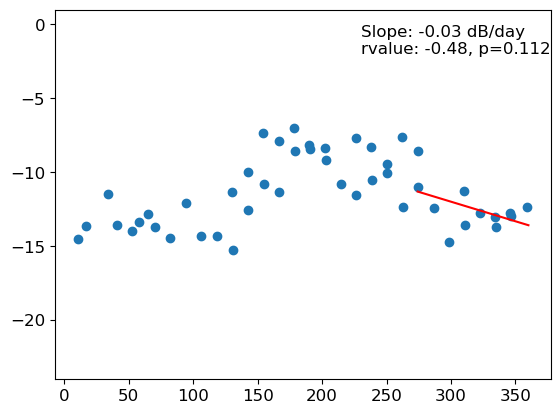

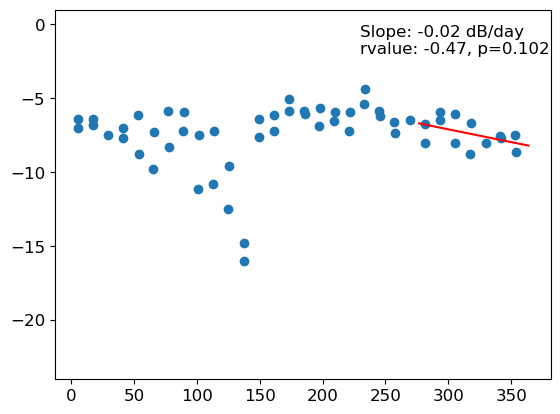

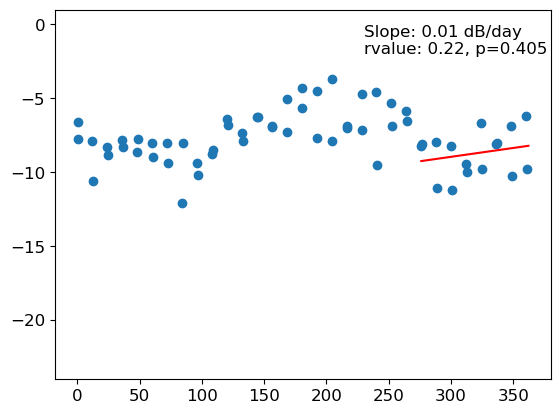

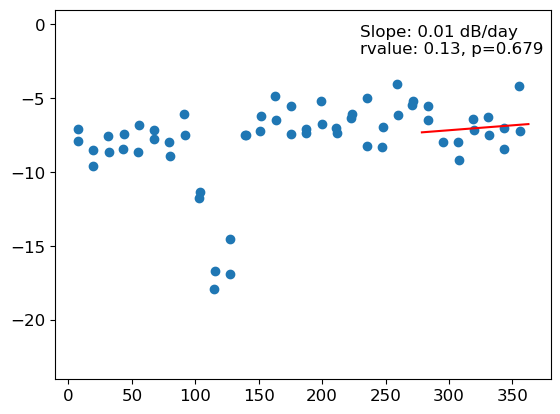

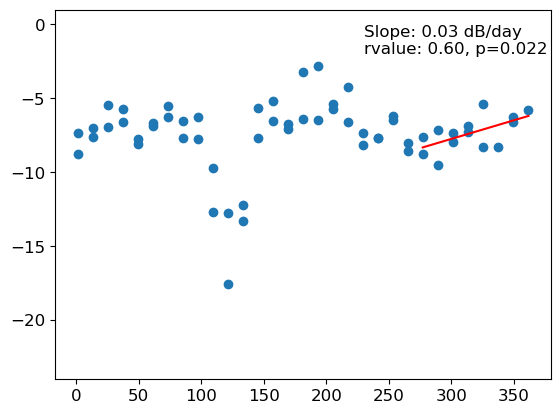

In [49]:
yearlist = range(2017,2022)

for year in yearlist:
    data = []
    projdir = Path.home()/"GlacierSARdata"
    projname = 'Wrangell'
    # year = 2021
    data_dir=Path(f'{projdir}/{projname}/{str(year)}')
    # pols = ['VV','VH']

    # Setting Paths
    analysis_directory = Path.cwd()/data_dir

    #Open metadata
    usepol = 'VV'
    (arraykey,pnamelist,mnamelist,mdatelist,mpflist,mpfulist) = np.load(f'{str(analysis_directory)}/imgmeta_{usepol}.npy',allow_pickle=True)
    mpfunique = np.unique(mpfulist)
    chunkmeta = opendatamem(pnamelist)
    admeta = adjust_meta(chunkmeta,mpfulist,mpfunique,mdatelist,settomean=True)

    datelist = np.array(mdatelist)
    juldates = juliandate(datelist,year)
    datevec = np.array(juldates)
    fallstart = datetime(year,10,1)
    fallend = datetime(year+1,1,1)

    fallstart = juliandate(fallstart,year)
    fallend = juliandate(fallend,year)

    # print(fallstart)
    # print(fallend)

    # ipt,jpt = 1000,1300  #wrangell aquifer
    # ipt,jpt = 770,950 #Wrangell near summit (dry firn)
    ipt,jpt = 1470,800  #Glacier coming off wrangell, with snow melt then bare ice
    dvec = opendatavec(pnamelist,ipt,jpt,admeta, mpfulist)

    dfvec = dvec[(datevec >= fallstart) & (datevec <= fallend)]
    datefvec = datevec[(datevec >= fallstart) & (datevec <= fallend)]
    fmask = ~np.isnan(dfvec)

    res = stats.linregress(datefvec[fmask],dfvec[fmask])
    # print(res)
    restext = f'Slope: {res.slope:.2f} dB/day\nrvalue: {res.rvalue:.2f}, p={res.pvalue:.3f}'

    plt.figure()
    plt.plot(juldates, dvec, 'o', label='original data')
    plt.plot(datefvec, res.intercept + res.slope*datefvec, 'r', label='fitted line')
    plt.ylim([-24,1])
    plt.text(230,-2,restext)
    plt.savefig(projdir/"figures"/f'SinglePoint_{projname}_i{ipt}j{jpt}_{year}.png')

In [6]:
#lin regress map

mask = np.load(analysis_directory/"masksmall.npy")

fallstart = datetime(year,10,1)
fallend = datetime(year+1,1,1)

fallstart = juliandate(fallstart,year)
fallend = juliandate(fallend,year)

juldates = juliandate(datelist,year)

fsmap = np.zeros(np.shape(mask))
frmap = np.zeros(np.shape(mask))
fsmap[~mask]=np.nan
iipts,jjpts = np.where(mask==1)
fullcount = len(iipts)
# print(upts)

t = time.time()
countdiv = int(np.floor(fullcount/200))
for kk,ii in enumerate(iipts):
    jj = jjpts[kk]

    dvec = np.array(data[:,ii,jj])
    datevec = np.array(juldates)
    
    datevec = datevec[~np.isnan(dvec)]
    dvec = dvec[~np.isnan(dvec)]
    
    dvec = dvec[(datevec >= fallstart) & (datevec <= fallend)]
    datevec = datevec[(datevec >= fallstart) & (datevec <= fallend)]
    
    res = stats.linregress(datevec,dvec)

    fsmap[ii,jj] = res.slope
    frmap[ii,jj] = res.rvalue
    
    if kk % countdiv == 0:
            if kk > 0:
                count = kk
                te = time.time()-t  #time elapsed
                print(f'Current progress: {count}/{fullcount}, time elapsed: {te/60:.2f} min,'
                          f' time remaining: {(te/(kk+1)*(fullcount-count-1))/60:.2f} min\f',end="\r")
    
    # fsmap = 

In [53]:
# # np.shape(mask)
# # 1519*2263
# a=np.arange(12)
# a=a.reshape(3,4)
# np.where(a>6)

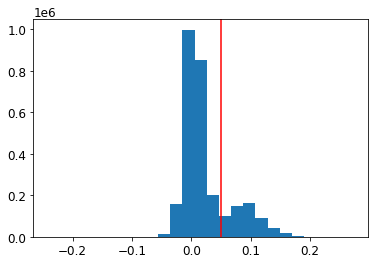

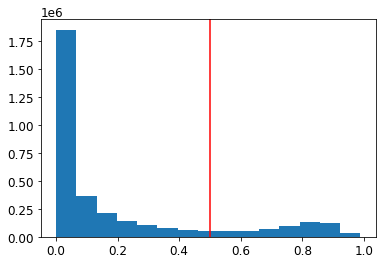

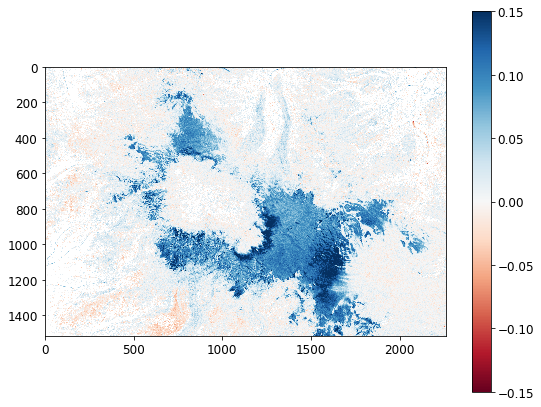

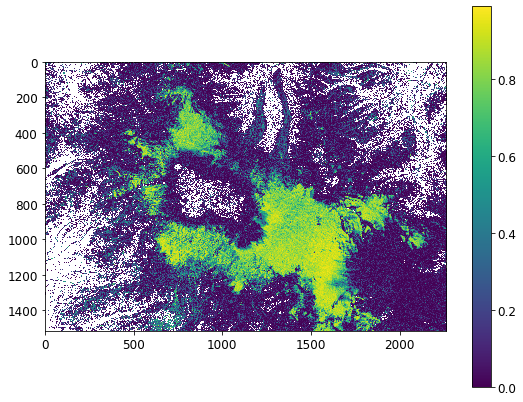

In [7]:
plt.figure()
plt.hist(fsmap.flatten(),bins=25)
plt.axvline(x=0.05,color='r')

plt.figure()
plt.hist((frmap*frmap).flatten(),bins=15)
plt.axvline(x=0.5,color='r')

fssafe = np.array(fsmap)
# fssafe[np.abs(fssafe)<0.05]=np.nan

plt.figure(figsize=(9,7))
plt.imshow(fssafe,interpolation='nearest',vmin=-.15,vmax=.15,cmap='RdBu')
plt.colorbar()
plt.savefig(analysis_directory/"figures"/"fallslope.png")

frsafe = np.array(frmap)
frsafe[~mask]=np.nan
frsafe = frsafe*frsafe
# frsafe[frsafe<0.5]=np.nan

plt.figure(figsize=(9,7))
plt.imshow(frsafe,interpolation='nearest')#,vmin=0,vmax=.95)
plt.colorbar()
plt.savefig(analysis_directory/"figures"/"fallr.png")

In [55]:
# int(np.floor(12357673/123))

100468.0

## Aquifer Identification Grand

In [6]:
projlist = ['Juneau','Wrangell','Harding','Denali_h']
# projlist = ['Harding','Denali_h']
yearlist = [2017,2018,2019,2020,2021]
pol='VV'

class fallslope:
    """only fall dates get passed in"""
    def __init__(self,datelist,dvec):
        #do regression if there are at least 2 points
        if np.sum(np.isnan(dvec))<len(dvec)-1:
            res = stats.linregress(datevec,dvec)
            self.slope = res.slope
            self.rvalue = res.rvalue
        else:
            self.slope = np.nan
            self.rvalue = np.nan


for proj in projlist:
    #OPEN IT
    for year in yearlist:
        print(f'\n {proj} {year}')
        
        if proj=='Harding':
            if year==2017:
                continue
        
        data_dir=Path(f'{projdir}/{proj}/{str(year)}')

        # Setting Paths
        analysis_directory = Path.cwd()/data_dir
        print(f"analysis_directory: {analysis_directory}")

        download_path = analysis_directory/"rtc_download"
        products_path = analysis_directory/"rtc_products"
        clipped_path = analysis_directory/"rtc_clipped"

        (arraykey,pnamelist,mnamelist,mdatelist,mpflist,mpfulist) = np.load(f'{str(analysis_directory)}/imgmeta_{pol}.npy',allow_pickle=True)
        mpfunique = np.unique(mpfulist)
        __,meltlen,__ = np.load(f'{str(data_dir)}/meltseason.npy',allow_pickle=True)
        datelist = np.array(mdatelist)
        
        mask = np.zeros(np.shape(meltlen))
        mask[meltlen>0]=1

        chunkmeta = opendatamem(pnamelist)
        admeta = adjust_meta(chunkmeta,mpfulist,mpfunique,mdatelist,setdb=0)
        pnamelist,istart,iend,jstart,jend,b2,shp = chunkmeta        
        klen,ilen,jlen = shp

        fallstart = datetime(year,10,1)
        fallend = datetime(year+1,1,1)

        fallstart = juliandate(fallstart,year)
        fallend = juliandate(fallend,year)

        juldates = juliandate(datelist,year)

        fsmap = np.zeros(np.shape(mask))
        frmap = np.zeros(np.shape(mask))
        fsmap[mask==0]=np.nan
        frmap[mask==0]=np.nan
        # iipts,jjpts = np.where(mask==1)
        fullcount = np.sum(mask)
        cpt = 0
        # print(upts)
        
        
        t = time.time()
        countdiv = int(np.floor(fullcount/200))
        
        for n in range(b2):
            data = opendatachunk(chunkmeta,n,admeta,mpfulist)
            print('                                              ', end="\r")
            for ic,it in enumerate(range(istart[n],iend[n])):
                for jc,jt in enumerate(range(jstart[n],jend[n])):
                    #Note: ic,jc are the index in the data chunk
                    #      it,jt are the index values of the whole image
                    
                    if mask[it,jt]==1:
                        dvec = np.array(data[:,ic,jc])
                        datevec = np.array(juldates)
                        
                        datevec = datevec[~np.isnan(dvec)]
                        dvec = dvec[~np.isnan(dvec)]

                        dvec = dvec[(datevec >= fallstart) & (datevec <= fallend)]
                        datevec = datevec[(datevec >= fallstart) & (datevec <= fallend)]
                        
                        res = fallslope(datevec,dvec)

                        fsmap[it,jt] = res.slope
                        frmap[it,jt] = res.rvalue
                        
                        cpt += 1
                        if cpt % countdiv==1:
                            count = cpt
                            te = time.time()-t  #time elapsed
                            np.save(f'{str(analysis_directory)}/fallslope_{pol}.npy',(fsmap,frmap))
                            print(f'Current progress: {count}/{fullcount}, time elapsed: {te/60:.2f} min,'
                                      f' time remaining: {(te/(cpt+1)*(fullcount-count-1))/60:.2f} min\f',end="\r")
            data = []
        np.save(f'{str(analysis_directory)}/fallslope_{pol}.npy',(fsmap,frmap))
                    
#         for kk,ii in enumerate(iipts):
#             jj = jjpts[kk]

#             dvec = np.array(data[:,ii,jj])
#             datevec = np.array(juldates)

#             datevec = datevec[~np.isnan(dvec)]
#             dvec = dvec[~np.isnan(dvec)]

#             dvec = dvec[(datevec >= fallstart) & (datevec <= fallend)]
#             datevec = datevec[(datevec >= fallstart) & (datevec <= fallend)]

#             res = stats.linregress(datevec,dvec)

#             fsmap[ii,jj] = res.slope
#             frmap[ii,jj] = res.rvalue

#             if kk % countdiv == 0:
#                     if kk > 0:
#                         count = kk
#                         te = time.time()-t  #time elapsed
#                         print(f'Current progress: {count}/{fullcount}, time elapsed: {te/60:.2f} min,'
#                                   f' time remaining: {(te/(kk+1)*(fullcount-count-1))/60:.2f} min\f',end="\r")


 Juneau 2017
analysis_directory: /home/jovyan/GlacierSARdata/Juneau/2017
just one chunk


/tmp/ipykernel_586/1885264266.py:134: RuntimeWarning: Mean of empty slice
  admeta[k,istart[n]:iend[n],jstart[n]:jend[n]] = np.nanmean(cdata[winterlist],axis=0)+setdb


Current progress: 5052001/5052195.0, time elapsed: 3.28 min, time remaining: 0.00 min
 Juneau 2018
analysis_directory: /home/jovyan/GlacierSARdata/Juneau/2018
chunky: 4
Current progress: 6359601/6359797.0, time elapsed: 19.86 min, time remaining: 0.00 min
 Juneau 2019
analysis_directory: /home/jovyan/GlacierSARdata/Juneau/2019
chunky: 4
Current progress: 6341601/6341736.0, time elapsed: 19.71 min, time remaining: 0.00 min
 Juneau 2020
analysis_directory: /home/jovyan/GlacierSARdata/Juneau/2020
chunky: 4
Current progress: 6418801/6418951.0, time elapsed: 19.98 min, time remaining: 0.00 min
 Juneau 2021
analysis_directory: /home/jovyan/GlacierSARdata/Juneau/2021
chunky: 4
Current progress: 6546201/6546241.0, time elapsed: 20.33 min, time remaining: 0.00 min
 Wrangell 2017
analysis_directory: /home/jovyan/GlacierSARdata/Wrangell/2017
just one chunk
Current progress: 2545201/2545305.0, time elapsed: 7.92 min, time remaining: 0.00 min
 Wrangell 2018
analysis_directory: /home/jovyan/G

### Now plot that


 Wrangell 2021


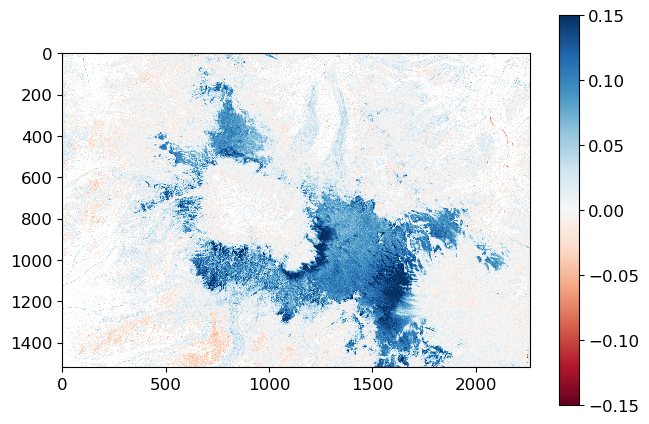

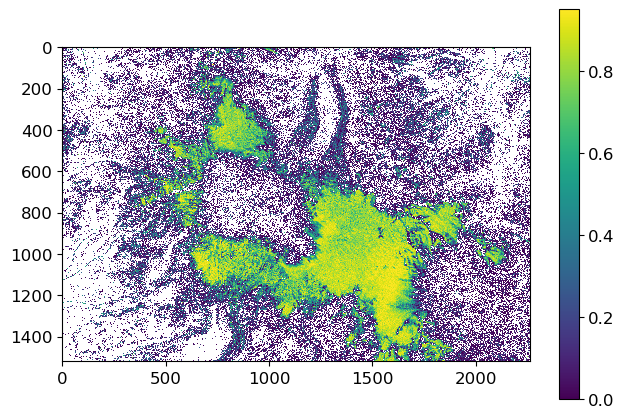

In [36]:
projdir = Path.home()/"GlacierSARdata"
# projlist = ['Juneau','Wrangell','Harding','Denali_h']
# projlist = ['Harding','Denali_h']
projlist = ['Wrangell']
# yearlist = [2017,2018,2019,2020,2021]
yearlist = [2021]
pol='VV'

for proj in projlist:
    #OPEN IT
    for year in yearlist:
        print(f'\n {proj} {year}')
        
        if proj=='Harding':
            if year==2017:
                continue
        
        data_dir=Path(f'{projdir}/{proj}/{str(year)}')

        # Setting Paths
        analysis_directory = Path.cwd()/data_dir

        # np.save(f'{str(analysis_directory)}/fallslope_{pol}.npy',(fsmap,frmap))
        fsmap,frmap = np.load(f'{str(analysis_directory)}/fallslope_{pol}.npy')
        
        fssafe = np.array(fsmap)
        # fssafe[np.abs(fssafe)<0.05]=np.nan

        ilen,jlen = np.shape(fsmap)
        dpi = 300
        xsz,ysz = jlen/dpi,ilen/dpi
        maxsz = 9 #in inches
        maxxy = np.max([xsz,ysz])
        if maxxy>maxsz:
            scf = maxsz/maxxy
            xsz,ysz = xsz*scf,ysz*scf
        
        plt.figure(figsize=(xsz,ysz))
        plt.imshow(fssafe,interpolation='nearest',vmin=-.15,vmax=.15,cmap='RdBu')
        plt.colorbar()
        plt.savefig(projdir/"figures"/f"fallslope_{proj}_{year}.png")
        # plt.savefig(analysis_directory/"figures"/"fallslope_{proj}_{year}.png")

        frsafe = np.array(frmap)
        # frsafe[~mask]=np.nan
        frsafe[fsmap<0]=np.nan
        frsafe = frsafe*frsafe
        # frsafe[frsafe<0.5]=np.nan

        plt.figure(figsize=(xsz,ysz))
        plt.imshow(frsafe,interpolation='nearest',vmin=0,vmax=.95)
        plt.colorbar()
        # plt.savefig(analysis_directory/"figures"/f"fallr_{proj}_{year}.png")
        # plt.plot([800],[1470],'o',markersize=5,color='r')
        plt.savefig(projdir/"figures"/f"fallr_{proj}_{year}.png")
        
# plt.figure()
# plt.hist(fsmap.flatten(),bins=25)
# plt.axvline(x=0.05,color='r')

# plt.figure()
# plt.hist((frmap*frmap).flatten(),bins=15)
# plt.axvline(x=0.5,color='r')



In [14]:
np.nansum(a-b)

0.0

In [13]:
a,b = np.load(analysis_directory/"fallslope_VV.npy")

In [50]:
def qnmask(vectors):
    """quick nan masks. Gimme tuple of vectors.
    Also this is untested. I wrote it and realized I didn't need it."""
    klen = len(vectors)
    mask = np.ones(np.shape(klen),dtype='bool')
    for vec in vectors:
        mask[np.isnan(vec)]=False
    return mask

## Aquifer Identification

Algorithm:
1. Identify surfaces that melt for 50 or more days. A melting seasonal snowpack is obviously not an aquifer.
2. Of those, do a linear regression on dB values for Oct 1 to Dec 31.
3. If the slope is greater than 0.05 dB/day and r^2 value >= than .5 (r value .75), it has an aquifer.

In [73]:
projdir = Path.home()/"GlacierSARdata"
# projlist = ['Juneau','Wrangell','Harding','Denali_h']
# projlist = ['Harding','Denali_h']
projlist = ['Wrangell']
# yearlist = [2017,2018,2019,2020,2021]
yearlist = [2021]
pol='VV'
mecrit = 50   #melt criteria
fscrit = 0.05 #fall slope criteria
frcrit = 0.9 #fall rvalue criteria


for proj in projlist:
    for year in yearlist:
        print(f'\n {proj} {year}')
        
        if proj=='Harding':
            if year==2017:
                continue
        
        data_dir=Path(f'{projdir}/{proj}/{str(year)}')

        # Setting Paths
        analysis_directory = Path.cwd()/data_dir

        # np.save(f'{str(analysis_directory)}/fallslope_{pol}.npy',(fsmap,frmap))
        fsmap,frmap = np.load(f'{str(analysis_directory)}/fallslope_{pol}.npy')
        __,meltlen,__ = np.load(analysis_directory/'meltseason.npy',allow_pickle=True)
        
        aqmap = np.zeros(np.shape(fsmap))
        #aqmap: 0: no melt,  1: melt >= 1 day,  2: melt >= 50 days,  3: aq identified
        aqmap[meltlen>=1]=1
        aqmap[meltlen>=mecrit]=2
        # aqtwos = aqmap[aqmap==2]
        fcrit = np.logical_and(fsmap>=fscrit, frmap>=frcrit)
        aqmask = np.logical_and(aqmap==2,fcrit)
        aqmap[aqmask]=3
        
        plt.figure()
        plt.imshow(aqmap,interpolation='nearest')
        plt.colorbar()
        
        print(np.sum(aqmap==3))


 Wrangell 2021
255097


In [56]:
a=np.arange(5)
b=np.arange(2,7)

# a[(a>2 & b>3)]
np.logical_and(a>2,b>5)

array([False, False, False, False, False])

In [ ]:
# for 5% increase or decrease
# mecrit
# 501566 to 501834

# fscrit
# 478361 to 515177

# frcrit
# 255097 to 547644